# Imports

In [7]:
#Note must do github installation first from github instructions
import beam_simulation as bs
#print("Loaded from:", bs.__file__)
from beam_simulation.create_oam_list import GenerateOAM

In [ ]:
# Standard library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam  

# Preprocessing Data

### Creating configuration of lab setup

In [4]:
cfg = bs.Config(
    wavelength=795e-9,
    size_x=200,
    size_y=200,
    pixel_size=1080*8e-6/200, #adjusted to approximate size of SLM
    w0=0.5e-3,
)

print("Default config now set to:")
print(bs.get_default_config())

Default config now set to:
Beam Simulation Configuration:
  Wavelength: 795.0 nm
  Beam waist (w0): 0.500 mm
  Size: 200 × 200 px
  Pixel size: 43.20 µm



### Generating OAM modes you want

In [8]:
gen = GenerateOAM(
    mode_types=["LG", "HG", "IG"],
    orders={
        "LG": {"p": [0, 1], "l": [1, 2]},
        "HG": {"n": [0, 1], "m": [1, 2]},
        "IG": {"p": [2], "m": [2]}
    },
    Cn2_list=[71.8e-13, 30.2e-12, 12e-12],
    n_samples=100
)

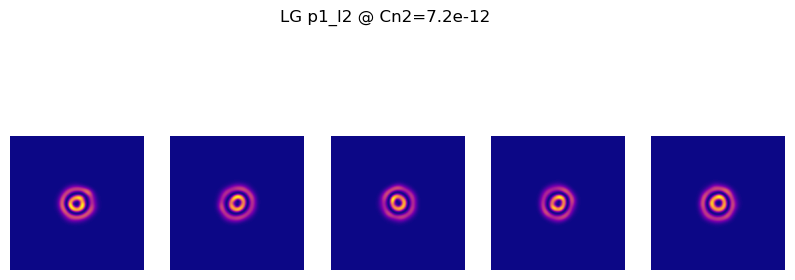

In [9]:
#Visualize a mode and order at a certain turbulence level
gen.visualize("LG", "p1_l2", Cn2=71.8e-13)

### Creating the dataset

In [32]:
data = gen.data
modes = ['LG', 'HG', 'IG']

images = []         #turbulent inputs
order_labels = []   #text labels like "LG_p1_l2"
crop = 30

for mode, orders in data.items():
    for order, turbulence_dict in orders.items():
        print(f"Processing {mode} {order}...")

        #Parse order string to extract indices 
        if mode == "LG":
            parts = order.replace("p", "").replace("_l", " ").split()
            p, l = map(int, parts)

        elif mode == "HG":
            parts = order.replace("n", "").replace("_m", " ").split()
            n, m = map(int, parts)

        elif mode == "IG":
            parts = order.replace("p", "").replace("_m", " ").split()
            p, m = map(int, parts)

        else:
            continue

        #Loop through turbulence
        for Cn2_level, image_list in turbulence_dict.items():
            for img in image_list:
                img = img[crop:-crop, crop:-crop] 

                images.append(img)
                order_labels.append(f"{mode}_{order}")


#Convert to arrays
images = np.array(images)
order_labels = np.array(order_labels)
images = images[..., np.newaxis]

#Encode string order labels numerically
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(order_labels)

print(f"Unique classes: {len(np.unique(order_labels))}")
print(f"Classes: {label_encoder.classes_}")
print(f"Image shape: {images.shape}, Label shape: {order_labels.shape}")

Processing LG p0_l1...
Processing LG p0_l2...
Processing LG p1_l1...
Processing LG p1_l2...
Processing HG n0_m1...
Processing HG n0_m2...
Processing HG n1_m1...
Processing HG n1_m2...
Processing IG p2_m2...
Unique classes: 9
Classes: ['HG_n0_m1' 'HG_n0_m2' 'HG_n1_m1' 'HG_n1_m2' 'IG_p2_m2' 'LG_p0_l1'
 'LG_p0_l2' 'LG_p1_l1' 'LG_p1_l2']
Image shape: (2700, 140, 140, 1), Label shape: (2700,)


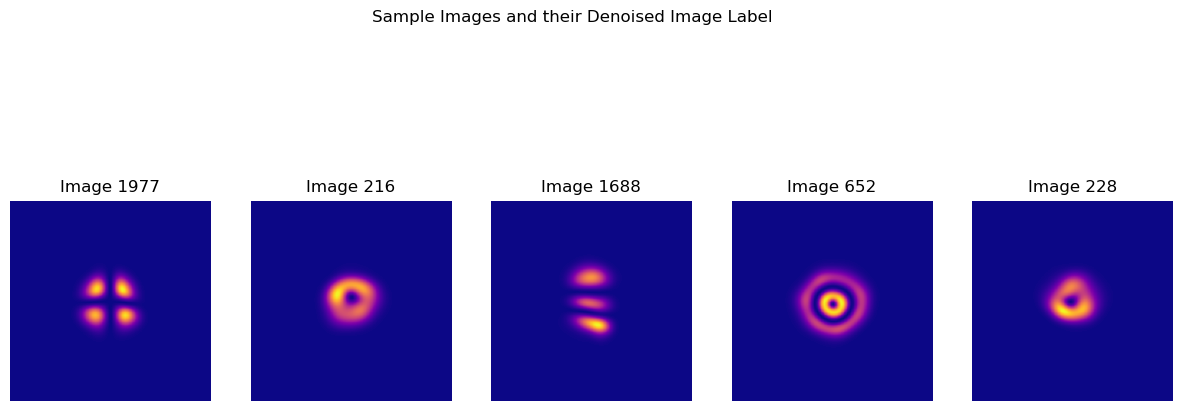

In [28]:
#Samples Images and Label
n=5
n_im = images.shape[0] 

fig, axs = plt.subplots(1, n, figsize=(3 * n, 6)) 
for i in range(n):
    random_index = np.random.randint(0, n_im)  #Randomly select idx
    axs[i].imshow(images[random_index], cmap='plasma')
    axs[i].axis('off') 
    axs[i].set_title(f'Image {random_index + 1}')
plt.suptitle("Sample Images and their Denoised Image Label")
plt.show()

# Final Results

This analysis: 
1. Trains the same model for all ranges of turbulence and for all modes. Labels are changed to define mode and order
2. Once the model is trained, it tests on the specific mode and turbulence data to classify the order.
3. This data is stored in ml_results_all and final_stats_ti
4. The process is repeated for several trials (if desired)

The **ml_results_all** dictionary saves the training/validation accuracy and loss versus epochs for our trained model and its ability to classify mode and order. This training is done for all of the turbulence levels and does not specify which one. It also makes predicitions on a test set that includes a wide range of turbulence levels and saves the corresponding confusion matrix for order and mode classification and labels needed for plotting. It only saves the results from the last trial.

## The model:

In [ ]:
#Dictionaries to save results
#The machine learning results for all the different modes on all turbulence levels training
ml_results_all = {}


Trial number: 0

Training labels ['HG_n0_m1' 'HG_n0_m2' 'HG_n1_m1' 'HG_n1_m2' 'IG_p2_m2' 'LG_p0_l1'
 'LG_p0_l2' 'LG_p1_l1' 'LG_p1_l2']
Epoch 1/15
64/64 [==============================] - 17s 254ms/step - loss: 0.5283 - accuracy: 0.8316 - val_loss: 2.3411 - val_accuracy: 0.1181
Epoch 2/15
64/64 [==============================] - 16s 258ms/step - loss: 0.1001 - accuracy: 0.9734 - val_loss: 4.0881 - val_accuracy: 0.1181
Epoch 3/15
64/64 [==============================] - 17s 262ms/step - loss: 0.0401 - accuracy: 0.9873 - val_loss: 5.2735 - val_accuracy: 0.1181
Epoch 4/15
64/64 [==============================] - 16s 253ms/step - loss: 0.0496 - accuracy: 0.9861 - val_loss: 6.6068 - val_accuracy: 0.1181
Epoch 5/15
64/64 [==============================] - 16s 249ms/step - loss: 0.0464 - accuracy: 0.9884 - val_loss: 3.8320 - val_accuracy: 0.4444
Epoch 6/15
64/64 [==============================] - 17s 272ms/step - loss: 0.0230 - accuracy: 0.9965 - val_loss: 0.7803 - val_accuracy: 0.7523
Epoch 

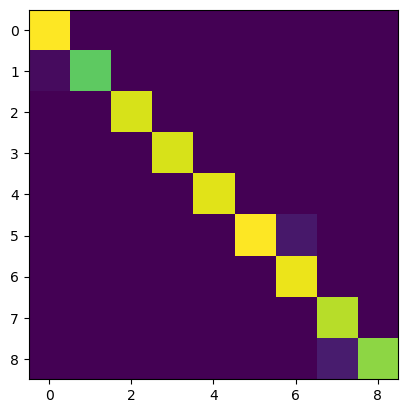

In [ ]:
n_trials = 1
epochs = 15

for trial in range(n_trials):
    print('')
    print(f'Trial number: {trial}')
    print('')
    #This will save each one as a seperate results so we can average afterwards
    if trial not in final_stats_ti:
        final_stats_ti[trial] = {}
    if trial not in ml_results_all:
        ml_results_all[trial] = {}

    X_train, X_test, y_train, y_test = train_test_split(images, numeric_labels, test_size=0.2, random_state=47,shuffle=True)
        
    #Transform labels from strings to integers
    print("Training labels",label_encoder.classes_)
    
    #MODEL
    model = models.Sequential([
        layers.Conv2D(128, (5, 5), strides = 2, activation='relu', input_shape=images[1].shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (5, 5), strides = 1, activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(64,activation='relu'),
        #layers.Dropout(0.2),
        layers.Dense(len(label_encoder.classes_), activation='softmax')  
    ])

    
    #Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    #Train the model
    history = model.fit(X_train, y_train, epochs=15, validation_split=0.2,verbose=True,batch_size=27)

    #Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    y_pred_prob = model.predict(X_test)  # Get predicted probabilities for each class

    #Get the index of the class with the highest probability for each sample
    y_pred = np.argmax(y_pred_prob, axis=1)
    
    #Create a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=label_encoder.transform(label_encoder.classes_))
    plt.imshow(conf_matrix)
    
    #Begin creating dictionary to save the results - This one stores all train/test loss and accuracy for everything not turbulence level  
    #Create an array of different types of data we would like to save for the modes for all turbulence levels
    types = ['loss', 'accuracy', 'val_loss', 'val_accuracy','cm','labels']
    for type_ in types:
        if type_ == 'cm':
            ml_results_all[trial][type_] = conf_matrix
        elif type_ == 'labels':
            ml_results_all[trial][type_] = label_encoder.classes_ 
        else:
            ml_results_all[trial][type_] = history.history[type_]

    ###############################################################################################################################

# Plotting

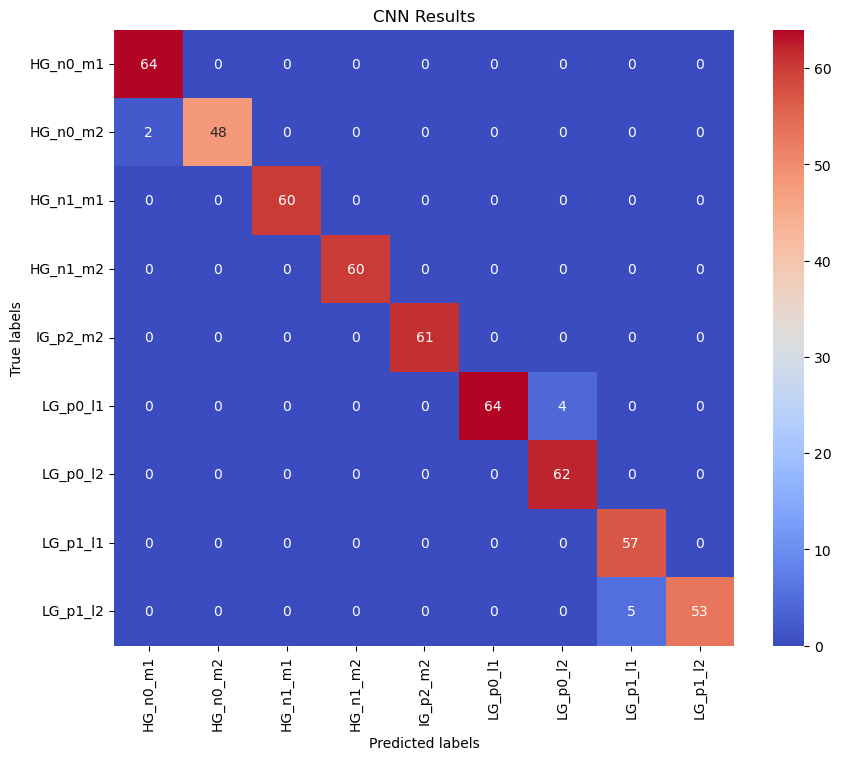

<Figure size 640x480 with 0 Axes>

In [45]:
plt.figure(figsize=(10, 8))
sns.heatmap(ml_results_all[0]["cm"], annot=True, fmt='d', cmap='coolwarm', 
            xticklabels= ml_results_all[0]['labels'], yticklabels=ml_results_all[0]['labels'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('CNN Results')
plt.show()
plt.tight_layout()

Text(0, 0.5, 'Accuracy')

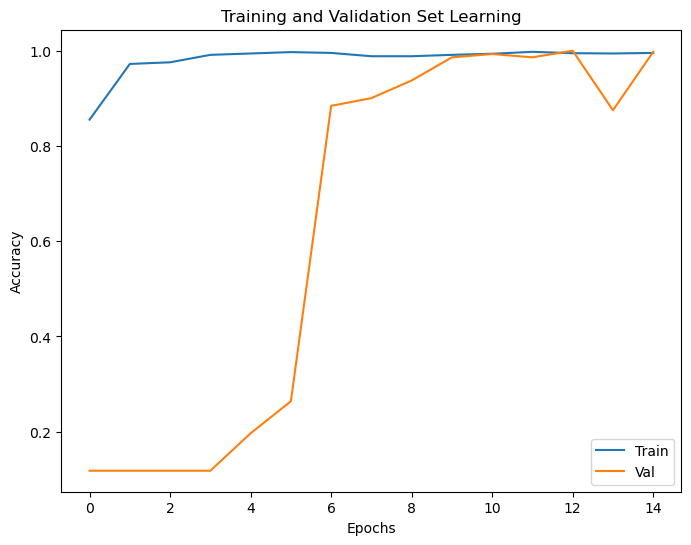

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(ml_results_all[0]["accuracy"], label = "Train")
plt.plot(ml_results_all[0]["val_accuracy"], label = "Val")
plt.title("Training and Validation Set Learning")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

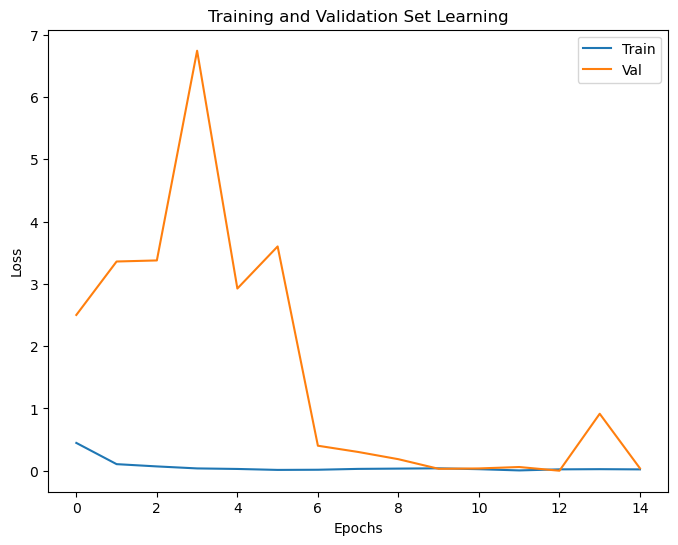

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(ml_results_all[0]["loss"], label = "Train")
plt.plot(ml_results_all[0]["val_loss"], label = "Val")
plt.title("Training and Validation Set Learning")
plt.xlabel("Epochs")
plt.legend()
plt.ylabel("Loss")